# Libraries

In [1]:
import sys
sys.path.append(r'C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/pytorch/pytorch-image-models')
import timm

In [2]:
timm.__version__

'0.8.1dev0'

In [3]:
import os
import sys
import shutil
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm

from tqdm.notebook import tqdm
import torchmetrics

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import f1_score,precision_score, recall_score

# Metric - Probabilistic F1

In [4]:
def probabilistic_f1(labels, predictions, beta=0.5):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
            cfp += 1 - prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return (result,c_precision,c_recall)
    else:
        return (0,0,0)

In [5]:
TRAIN_PATH = r"C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/dataset_image_crop_512"
TEST_PATH =  r"C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/test_img"

# Dataset

In [6]:
# read raw file
df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/5_folds_data.csv")
# add image filename columns
df["img_name"] = df["patient_id"].astype(str) + "/" + df["image_id"].astype(str) + ".png"
# shuffle it
df = df.sample(frac=1).reset_index(drop=True)

print(f"Data shape is {df.shape}") 

df.head()

Data shape is (54706, 16)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold,img_name
0,2,4784,560311838,R,MLO,53.0,0,0,0,NaN,0,NaN,21,False,1,4784/560311838.png
1,1,61486,2034843638,L,MLO,50.0,0,0,0,1.0,0,B,93,False,0,61486/2034843638.png
2,1,9410,136616753,R,CC,41.0,0,0,0,NaN,0,C,49,False,4,9410/136616753.png
3,2,55403,1954198160,L,MLO,54.0,0,0,0,NaN,0,NaN,29,False,0,55403/1954198160.png
4,2,60481,970992234,L,CC,63.0,0,0,0,NaN,0,NaN,48,False,2,60481/970992234.png


# Augmentation

In [7]:
transform_train = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomEqualize(),
                                      transforms.ToTensor()])

In [8]:
transform_valid = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor()])

# Create Dataset

In [28]:
class RSNADataset(Dataset):
    def __init__(self, df, img_folder, transform=None, is_test=False):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.is_test = is_test
    
    def __getitem__(self, idx):
        if self.is_test:
            dcm_path = os.path.join(self.img_folder, self.df["dcm_path"][idx])
            img = read_dicom(dcm_path)
        
            
            #print(img.shape)
        else:
            img_path = os.path.join(self.img_folder, self.df["img_name"][idx])
            img = cv2.imread(img_path,cv2.COLOR_BGR2GRAY)
        
            
            #print(img.shape)
        img = cv2.resize(img, (224, 224))
        if self.transform is not None:
            img = self.transform(img)    
        #img = torch.tensor(img,dtype=torch.float32)
        img = img.clone().detach()
        #img = img.permute(2, 1, 0)
        if not self.is_test:
            target = self.df["cancer"][idx]
            target = torch.tensor(target, dtype=torch.float32)
            return img, target
        img = img.unsqueeze(0)
        #print(img.shape)
        return img
    
    def __len__(self):
        return len(self.df)

# DataLoaders

In [29]:
ValidationFold = 0
train_df = df.query(f'fold != {ValidationFold}').reset_index(drop=True)
valid_df = df.query(f'fold == {ValidationFold}').reset_index(drop=True)

train_df.shape, valid_df.shape

((43727, 16), (10979, 16))

In [30]:
train_dataset = RSNADataset(df=train_df, img_folder=TRAIN_PATH, transform=transform_train) 
valid_dataset = RSNADataset(df=valid_df, img_folder=TRAIN_PATH, transform=transform_valid)
    
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [31]:
print(train_dataset[0][0].shape)

torch.Size([1, 224, 224])


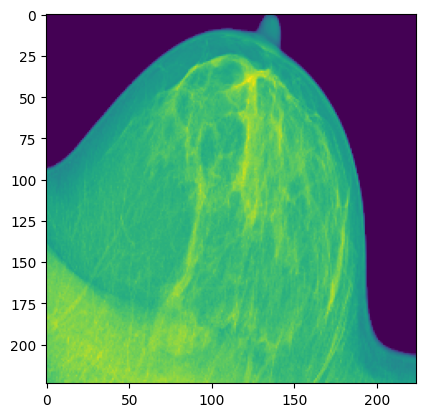

In [32]:
plt.imshow(train_dataset[0][0].permute(2, 1, 0).detach().cpu().numpy())

# Show Augmentations

In [33]:
def show_aug(inputs, targets, nrows=8, ncols=4, norm=False):
    plt.figure(figsize=(15,15 ))
    plt.subplots_adjust(wspace=0.2, hspace=1)
    i_ = 0
    
    if len(inputs) > 32:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.title(f"Label: {targets[idx].item()}")
        plt.imshow(img, cmap="bone"); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([16, 1, 224, 224]) torch.Size([16])


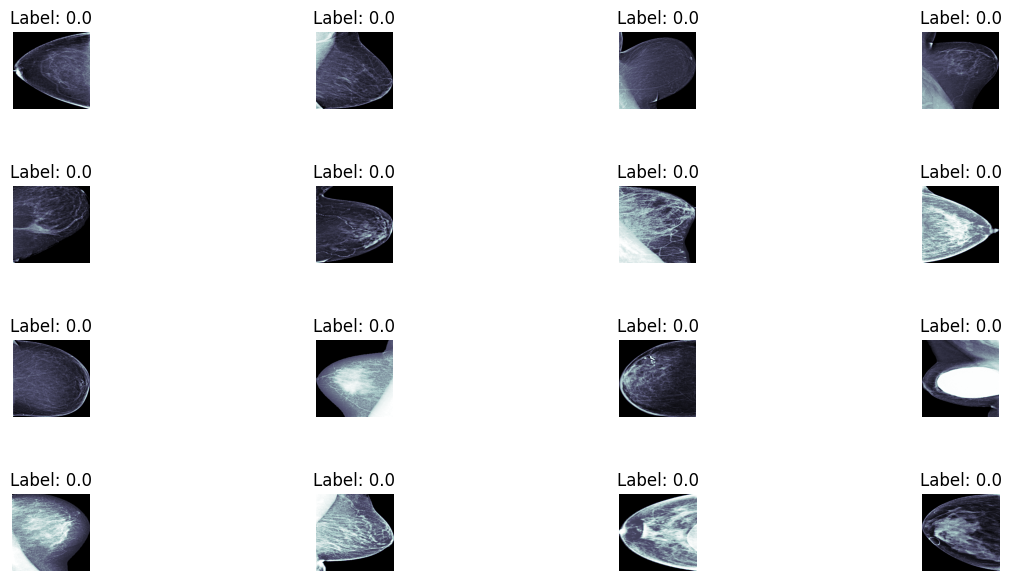

In [34]:
images, targets = next(iter(train_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

torch.Size([16, 1, 224, 224]) torch.Size([16])


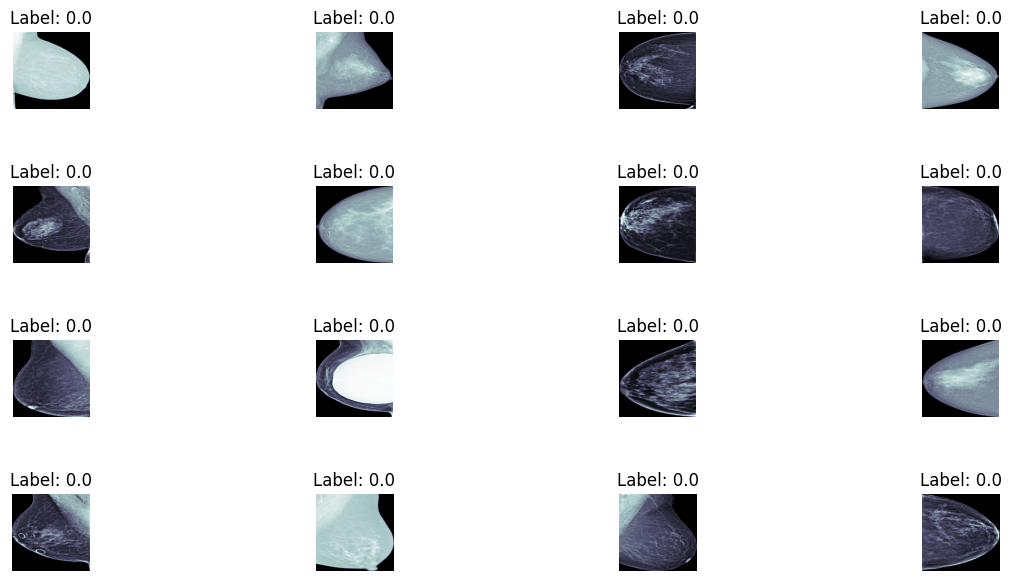

In [35]:
images, targets = next(iter(valid_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

# Model

In [36]:
#!pip install torchsummary 

In [37]:
from torchsummary import summary

In [38]:
class InceptionV4(torch.nn.Module):
    def __init__(self, model_name="inception_v4",pretrained=False, out_dim=1):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, in_chans=1)
        # adjust classifier
        self.backbone.last_linear = nn.Linear( self.backbone.last_linear.in_features, 
                             out_dim)
    def forward(self, x):
        return self.backbone(x)

In [39]:
InceptionV4()

InceptionV4(
  (backbone): InceptionV4(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): Mixed3a(
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv): BasicConv2d(
          (conv): Conv2d(64, 96, kernel_size=(3, 3), stri

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [41]:
#effi = Efficientnet_l2().to(device)
#summary(effi,(1,224,224))

In [42]:
n_epochs = 10

# Binary Focal Loss

In [43]:
import torch
import torch.nn.functional as F


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
):
    """
    Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default = 0.25
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

In [44]:
def fit(model, epochs, train_loader, valid_loader, optimizer,loss_fn):
    
    train_loss, val_loss = [], []
    f1_score_hist = []
    
    for ep in tqdm(range(epochs+1)):
        print(f"{35*'='} Epoch:{ep+1} {35*'='}")
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        # training
        model.train()
        for idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images).view(-1)
            targets = targets.unsqueeze(1)
            loss = sigmoid_focal_loss(outputs,targets.float())
            #loss = loss_fn(outputs, targets.float())
            
                        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
            
            if idx % 1000 == 0:
                print(f"Batch: {idx} | Train Batch Loss: {loss.item():.4f}")
        
        train_loss.append(running_loss / len(train_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Training Loss: {np.mean(train_loss):.4f}\n")
        
        
        # validation        
        all_outputs, all_targets = [], []
        correct_t = 0
        batch_loss = 0
        total_t = 0
        model.eval()
        with torch.no_grad():
            
            for idx, (images_t, targets_t) in enumerate(valid_loader):
                images_t = images_t.to(device)
                targets_t = targets_t.to(device)
                
                outputs_t = model(images_t).view(-1)
                targets_t = targets_t.unsqueeze(1)
                #loss_t = loss_fn(outputs_t, targets_t.float())
                loss_t = sigmoid_focal_loss(outputs_t,targets_t.float())
                
                batch_loss += loss_t.item()
                
                if idx % 1000 == 0:
                    print(f"\nBatch: {idx} | Valid Batch Loss: {loss_t.item():.4f}")
                
                all_outputs.extend(torch.sigmoid(outputs_t).cpu().detach().tolist())
                all_targets.extend(targets_t.cpu().detach().tolist())
        prob_f1_score= probabilistic_f1(all_targets, all_outputs)
        
        f1_score_hist.append(prob_f1_score)
        val_loss.append(batch_loss/len(valid_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Validation Loss: {np.mean(val_loss):.4f}\n")
        print(f"\nF1 Score for Epoch {ep +1}: {prob_f1_score:.4f}\n")
        if (ep%2)==0:
            torch.save(model.state_dict(), "C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/efficientv2.pt")
        
    return train_loss, val_loss, f1_score_hist

In [45]:
def run(train_loader, val_loader, epochs=n_epochs):
    model = InceptionV4().to(device)
    
    optimizer = torch.optim.Adam(params=model.parameters(),weight_decay=1e-2,lr = 1e-4)
    #loss_fn = nn.BCEWithLogitsLoss()
  
    loss_fn = sigmoid_focal_loss(inputs= torch.Tensor(model(images.to(device)).view(-1)),
                                 targets= torch.Tensor(targets.to(device).float()),
                                 gamma=2.0,
                                 alpha = 0.8,
                                 reduction="mean")
    
    train_loss, val_loss, f1_score_hist = fit(model=model, epochs=epochs, train_loader=train_loader,
        valid_loader=val_loader, optimizer=optimizer,
       loss_fn=loss_fn)
    return train_loss, val_loss, f1_score_hist

# Train the Model

In [46]:
train_loss, val_loss, f1_score_hist = run(train_loader, valid_loader, n_epochs)

  0%|          | 0/11 [00:00<?, ?it/s]

=================================== Epoch:1 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([16, 1])) must be the same as input size (torch.Size([16]))

In [27]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train loss', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation loss', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

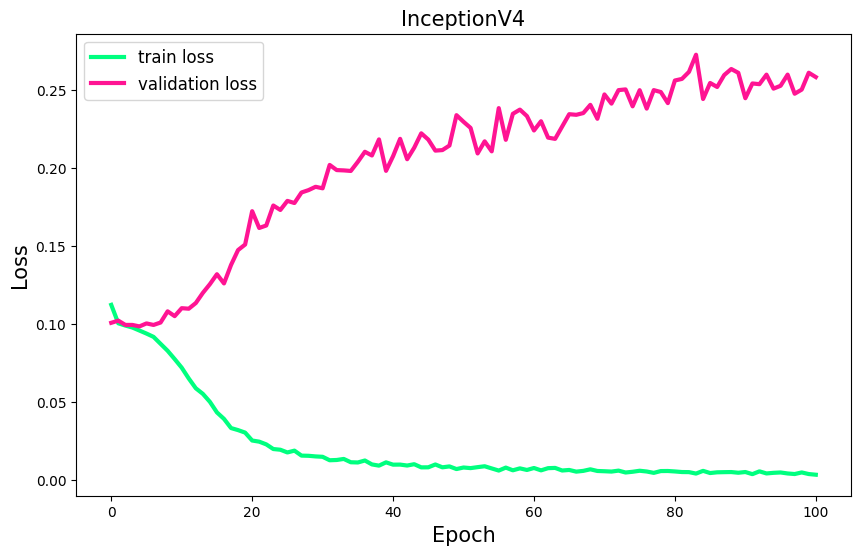

In [28]:
plot_model_history("InceptionV4", train_loss, val_loss, num_epochs=n_epochs+1)

# * predict

In [22]:
#!pip install dicomsdl
import dicomsdl

In [23]:
def read_dicom(path, fix_monochrome = True):
    dicom = dicomsdl.open(path)
    data = dicom.pixelData(storedvalue=True)  # storedvalue = True for int16 return otherwise float32
    data = data - np.min(data)
    data = data / np.max(data)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

In [24]:
df_test = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/test.csv")
df_test["img_name"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".png"
df_test["dcm_path"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".dcm"

df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,img_name,dcm_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,10008/736471439.png,10008/736471439.dcm
1,2,10008,1591370361,L,CC,81,0,21,10008_L,10008/1591370361.png,10008/1591370361.dcm
2,2,10008,68070693,R,MLO,81,0,21,10008_R,10008/68070693.png,10008/68070693.dcm
3,2,10008,361203119,R,CC,81,0,21,10008_R,10008/361203119.png,10008/361203119.dcm


In [25]:
class RSNADataset1(Dataset):
    def __init__(self, df, img_folder):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_folder, self.df["img_name"][idx])
        img = cv2.imread(img_path)

        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img)
        #img = img.clone().detach()
        img = img.permute(2, 1, 0)
        
        #img = img.unsqueeze(0)
        #print(img.shape)
        return img
    
    def __len__(self):
        return len(self.df)

In [26]:
test_dataset=RSNADataset1(df=df_test, img_folder=TEST_PATH)
print((test_dataset[0]).shape)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([3, 224, 224])


In [28]:
img=torch.Tensor(test_dataset[0])
print(img.shape)

torch.Size([3, 224, 224])


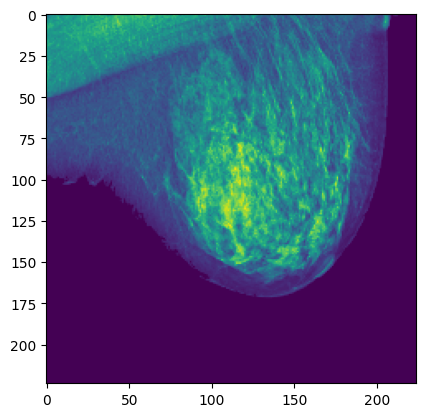

In [29]:
plt.imshow(next(iter(test_loader))[0][0])

In [30]:
for i in next(iter(test_loader)):
    print(i.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [36]:
def prediction_model(model, test_loader):    
    model.eval()
    
    with torch.no_grad():
        preds = []
        if len(test_loader) != 1:
            # there are images and targets in loader in batches
            for images, targets in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(images):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
        else:
            # just images
            for batch in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(batch):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
            
        return torch.cat(preds).numpy()

In [37]:
preds = prediction_model(InceptionV4(), test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [38]:
preds

array([[-0.30547464],
       [-0.30900723],
       [-0.31688434],
       [-0.29979384]], dtype=float32)

In [153]:
def logistic_id(x):
    return (1/(1+np.exp(-x)))

In [154]:
scaled_preds = logistic_id(preds) 

In [161]:
scaled_preds

array([[0.6198474 ],
       [0.62248105],
       [0.6211243 ],
       [0.62484294]], dtype=float32)

In [162]:
sub_df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/sample_submission.csv")
sub_df.head()

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [163]:
prediction_id = df_test['patient_id'].astype(str) + "_" + df_test['laterality']
prediction_id

0    10008_L
1    10008_L
2    10008_R
3    10008_R
dtype: object

In [166]:
data = {"prediction_id": np.array(list((prediction_id))),
        "cancer": scaled_preds.T[0]
}

sub_df = pd.DataFrame(data=data)

In [167]:
sub_df

,prediction_id,cancer
0,10008_L,0.619847
1,10008_L,0.622481
2,10008_R,0.621124
3,10008_R,0.624843


In [172]:
subb = sub_df.groupby('prediction_id')[['cancer']].median()
subb

,cancer
prediction_id,
10008_L,0.621164
10008_R,0.622984


In [173]:
subb.to_csv('submission.csv',index = True)

# Fuzy rank-based Fusion using Gompertz funtion 

In [ ]:
def fuzzy_rank(CF, top):
    R_L = np.zeros(CF.shape)
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            for k in range(CF.shape[2]):
                R_L[i][j][k] = 1 - math.exp(-math.exp(-2.0*CF[i][j][k]))  #Gompertz Function
    
    K_L = 0.632*np.ones(shape = R_L.shape) #initiate all values as penalty values
    for i in range(R_L.shape[0]):
        for sample in range(R_L.shape[1]):
            for k in range(top):
                a = R_L[i][sample]
                idx = np.where(a==np.partition(a, k)[k])
                #if sample belongs to top 'k' classes, R_L =R_L, else R_L = penalty value
                K_L[i][sample][idx] = R_L[i][sample][idx]

    return K_L

def CFS_func(CF, K_L):
    H = CF.shape[0] #no. of classifiers
    for f in range(CF.shape[0]):
        for i in range(CF.shape[1]):
            idx = np.where(K_L[f][i] == 0.632)
            CF[f][i][idx] = 0
    CFS = 1 - np.sum(CF,axis=0)/H
    return CFS

def Gompertz(top = 2, *argv):
    L = 0 #Number of classifiers
    for arg in argv:
        L += 1

    num_classes = arg.shape[1]
    CF = np.zeros(shape = (L,arg.shape[0], arg.shape[1]))

    for i, arg in enumerate(argv):
        CF[:][:][i] = arg

    R_L = fuzzy_rank(CF, top) #R_L is with penalties
    
    RS = np.sum(R_L, axis=0)
    CFS = CFS_func(CF, R_L)
    FS = RS*CFS

    predictions = np.argmin(FS,axis=1)